# Naive Bayes

## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model).

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, flatten each image to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
>```
mnist = sklearn.datasets.fetch_mldata('MNIST original')
```

to fetch the original data. You may set the `data_home` to where you wish to download your data for caching. Each image is already transformed into a 1D integer array $x\in 
[0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.

---
**Note 1:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. 
This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. 
Feel free to test the proformance of the algorithms below on the preprocessed data as well.

**Note 2:**
Since ML-Data is deprecated, you may wish to use something like this:
>```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
  ```



In [126]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [127]:
# data = sklearn.datasets.fetch_openml('mnist_784')

In [128]:
from keras.datasets import mnist; 

In [129]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#automatically splits 6:1.

In [130]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

(28, 28)

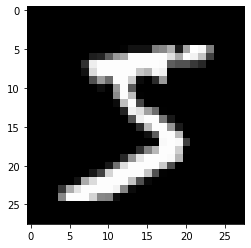

In [131]:
image = x_train[0]
fig = plt.figure()
plt.imshow(image, cmap = 'gray')
image.shape #(28 by 28, so 784 pixels)

In [132]:
x_train = x_train.reshape(x_train.shape[0], 784) #flattent the arrays for analysis
x_test = x_test.reshape(x_test.shape[0], 784)

### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability, P(y\x)) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 


**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

#### Answer 1
Any value above 0 will be converted to a 1, and all 0's will remain a 0. This means though, that many of our values will be "0", which the regular Bayes algorithm wouldn't handle well without laplace. Therefore, our updated probability is equal to:

P(Xi\y) = P(i\y)Xi + (1-P(i\y))(1-Xi), where Xi is either 1 or 0.

P(y\x) = argmax( P(x1\y)*P(x2\y) .... *P(xn\y)*P(y) ) for each class.

Prior: Probability of getting any given label (how many 1's are in the data set?)
Likelihood: Each xi is a position in the array (the features are the positions). So given label = 3, and looking at position 0: We look at all of the position 0's for label 1, and calculate amount of 1's which appear in position 0 for 3, and calculate the amount of 0's which appear in position 0 for label 3. Each of these are the likelihoods.

(We don't need the Evidence, because we are just looking for an argmax)

In [133]:
#For label = 3:
prior = len(y_train[y_train == 3]) / len(y_train)
prior

0.10218333333333333

In [134]:
#convert values greater than 0 to 1.
x_example = x_train.copy()
x_example[x_example > 0] =1

#Looking at the 200th position

samp_space = x_example[y_train== 3]
len(samp_space)

6131

In [135]:
loc = 350
ones = len(samp_space[samp_space[:,loc] ==1])

zeros = len(samp_space[samp_space[:,loc] ==0])
ones, zeros


(5633, 498)

In [136]:
tot = len(samp_space[:, loc])
ones_prob = ones/tot
zeros_prob = zeros/tot
likelihood = ones_prob
likelihood

0.9187734464198336

In [137]:
zeros_prob

0.08122655358016637

In [138]:
likelihood*prior

0.09388333333333333

However, this was just the calculation of the likelihood for one feature. Naive Bayes says that we can calculate the likelihood by doing
P(x1\y)*P(x2\y)*P(xn\y)*P(y).
Therefore we would calculate the likelihood of each x, multiply them together, then multiply by the prior. 

We would do this for every label. We would then have 10 probabilities, and our choice would be that with the maximum likelihood.

#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


#### Answer 2
Put you answer here...

Bayes uses log probabilities, a thorough explanation is found in this article. The basic reason is, because the multiplication of probabilities between 0 and 1 can become unworkable, and difficult copmutationally (lots of float digits).

https://www.cs.rhodes.edu/~kirlinp/courses/ai/f18/projects/proj3/naive-bayes-log-probs.pdf

Notice that the log probabilites are negative probabilies. This is okay, and we don't need to swich from argmax to argmin.

Example: say you have the probabilities 0.2 and 0.3. Note that ln(0.2) =  −1.6 and  ln(0.3) −1.2. The comparisons are preserved: 0.2 < 0.3 and −1.6 < −1.2.

In [139]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(binarize= 0)
clf.fit(x_train, y_train) 
#Fit here doesn't do any prediction, rather it just creates a "bag" of counts and probabilities for each feature and each label.
#predict is what actually uses the Naive Bayes model, to calculate the likelihoods for each feature in the given vector(s).

BernoulliNB(binarize=0)

##### 1) Average Picture:

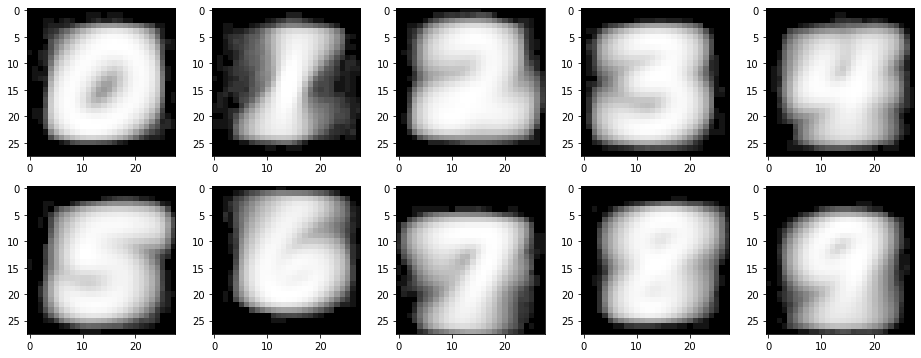

In [140]:
fig = plt.figure(figsize=(16,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(clf.feature_log_prob_[i].reshape(28,28), cmap= 'gray')

##### 2) Random Generation

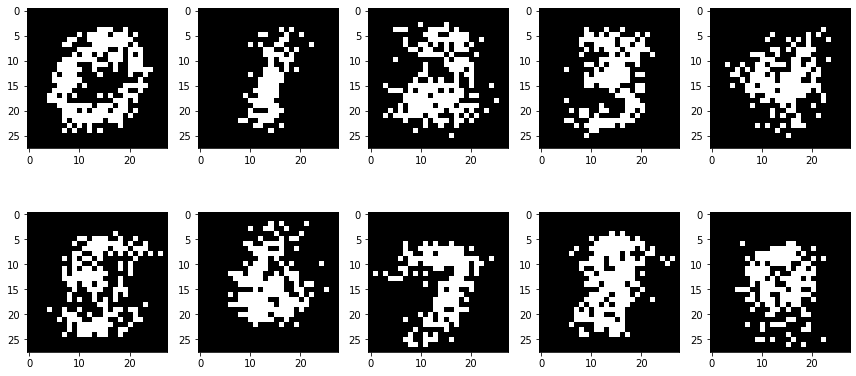

In [141]:
#need to generate an image
fig = plt.figure(figsize= (12,6))
for n in range(10):
    plt.subplot(2,5,n+1)
    prob = np.exp(clf.feature_log_prob_[n])
    random_nums = np.random.rand(len(clf.feature_log_prob_[n]))
    digits = []


    for i in range(len(prob)):
        #The probability of a pixel being black in a digit class is high (likely part of a given class). Given a random number 'i', 
        # the more likely that this area is to be part of a class, the more likely that a random number 'i' will be smaller than that probability.
        if random_nums[i] <= prob[i]:
            digits.append(1)
        else:
            digits.append(0)
    plt.imshow(np.array(digits).reshape(28,28), cmap= 'gray')
plt.tight_layout()

##### 3) Prediction and Accuracy

In [142]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = clf.predict(x_test)
conf = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
#accuracy = np.diagonal(conf).sum() / len(y_test)
print(f'accuracy: {acc},\nconfusion matrix: \n{conf}')

accuracy: 0.8413,
confusion matrix: 
[[ 887    0    4    7    2   41   16    1   22    0]
 [   0 1085   10    5    0    9    6    0   19    1]
 [  19    8  852   29   17    4   32   14   55    2]
 [   5   15   34  844    0   13    9   15   49   26]
 [   2    6    4    0  795    4   21    1   23  126]
 [  23   12    7  129   30  627   16    8   21   19]
 [  18   18   15    2   13   35  851    0    6    0]
 [   1   24   14    4   15    0    0  871   27   72]
 [  16   23   13   76   17   22    7    6  758   36]
 [   9   13    5    9   74    8    0   24   24  843]]


Results Summary:

Our classifier correctly classified each image 84% of the time. This is good, however, imporvements could be made. We made an assumption that any digit above 0 should be converted into a 1. However, we can make a better threshold for our binomial conversion, to make our model more accurate. By raising the threshold (even for each individual class) we can remove outliers for each class, and more heavily weigh the pixels which are more "solidly" a part of each class, as opposed to the edges.

## 2. Classifing Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.


* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* Write a class `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.
* use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`. If there are differences try to think why
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).

### Optional: Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words. 

Bonus: How can you correct the analyzed error? 

To read more about model interpretation, see the blogpost below and my tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

In [143]:
import string
def print_txt(txt, hot, cold):
  """
  print the text, coloring hot and cold words with colors
  """
  cold_color='\x1b[41;37m{}\x1b[0m'
  hot_color='\x1b[42;37m{}\x1b[0m'
  def color(token):
    lower = str(token).lower()
    lower = lower.replace('\t','').replace('\n','')
    lower = lower.translate(string.punctuation)
    if (lower in hot) and (lower in cold):
      return mid_color.format(token)
    elif lower in hot:
      return hot_color.format(token)
    elif lower in cold:
      return cold_color.format(token)
    else:
      return token
  colored_txt = " ".join([color(token) for token in txt.split(' ')])
  print(colored_txt)
print_txt('This word support the first class but this the other', ['word'],['other'])

This word support the first class but this the other


In [144]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


In [145]:
train_news = fetch_20newsgroups(remove = ('headers', 'footers', 'quotes'))
test_news = fetch_20newsgroups(subset= 'test', remove = ('headers', 'footers', 'quotes'))

In [146]:
class NaiveBayes():
    """ DIY binary Naive Bayes classifier based on categorical data """

    def __init__(self, alpha=1.0):
        """ """
        # self.prior = None
        # self.word_counts = None
        # self.lk_word = None
        self.alpha = alpha
        # self.is_fitted_ = False

    def fit(self, X: np.ndarray, y: np.ndarray):

        self.classes = np.unique(y) #len(classes)
        self.X_by_class = np.array([X[y == c] for c in self.classes])
        self.prior = np.array([X_class.shape[0] / len(self.classes) for X_class in self.X_by_class])

        self.word_counts = []
        self.lk_words = []
        for matrix_per_class in self.X_by_class:
            word_count = np.array(np.sum(matrix_per_class, axis=0)  + self.alpha).reshape(-1,1) #added dimension while creating array, reshape gets rid of it.
            self.word_counts.append(word_count)

            lk_word = word_count / np.sum(word_count)
            self.lk_words.append(lk_word)


    def predict_log_proba(self, x):
        self.log_probs_perClass = [] #Not sure which order to do htis in. Getting the wrong shape of 300,20. Not sure where 300 comes from.
        for i, text in enumerate(x.toarray()): #input is 
            text_probs = []
            for c in self.classes:
                word_exists = text.astype(bool)
                lk_words_present = self.lk_words[c].reshape(1,-1)[word_exists.reshape(1,-1)] #get the value in location where there is a value (as opposed to 0)
                text_probs.append(np.sum(np.log(lk_words_present)) + np.log(self.prior[c])) 
            self.log_probs_perClass.append(text_probs)
        return self.log_probs_perClass


    def predict(self, x):
        log_probabilities = self.predict_log_proba(x) #take out self?
        return np.argmax(log_probabilities, axis = 1)

### Accuracy and Classfication Report

In [147]:
# train_CV = CountVectorizer(stop_words= 'english')
# X = train_CV.fit_transform(train_news.data) #matrix
# y = train_news.target
# # vocab = count.vocabulary_

# test_CV = CountVectorizer(stop_words= 'english')
# test_x = train_CV.transform(test_news.data) #transform fits the dimensions to the fit_transform above.
#                                             #unseen words are just passed as 0 in the Naive Bayes, with laplace over it.
# test_y = test_news.target
# NB = NaiveBayes(alpha = 0.1)
# NB.fit(X, y)

In [148]:
X = train_news.data
y = train_news.target

test_x = test_news.data
test_y = test_news.target

In [149]:
pipeline = make_pipeline(CountVectorizer(stop_words= 'english'), NaiveBayes(alpha = 0.1))
pipeline.fit(X, y)
y_pred = pipeline.predict(test_x)

In [150]:
accuracy_score(test_y, y_pred)

0.6548061603823686

In [151]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.53      0.52       319
           1       0.55      0.72      0.62       389
           2       0.33      0.00      0.01       394
           3       0.52      0.71      0.60       392
           4       0.62      0.68      0.65       385
           5       0.74      0.73      0.73       395
           6       0.83      0.73      0.77       390
           7       0.73      0.73      0.73       396
           8       0.76      0.75      0.75       398
           9       0.90      0.78      0.84       397
          10       0.59      0.84      0.69       399
          11       0.74      0.74      0.74       396
          12       0.67      0.58      0.62       393
          13       0.82      0.77      0.80       396
          14       0.75      0.74      0.75       394
          15       0.58      0.82      0.68       398
          16       0.57      0.64      0.60       364
          17       0.80    

In [152]:
MNB = make_pipeline(CountVectorizer(stop_words= 'english'), MultinomialNB())
MNB.fit(X,y)
accuracy_score(test_y, MNB.predict(test_x))

0.6343600637280935

In [154]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(MultinomialNB(), CountVectorizer(stop_words= 'english').fit_transform(X), y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))



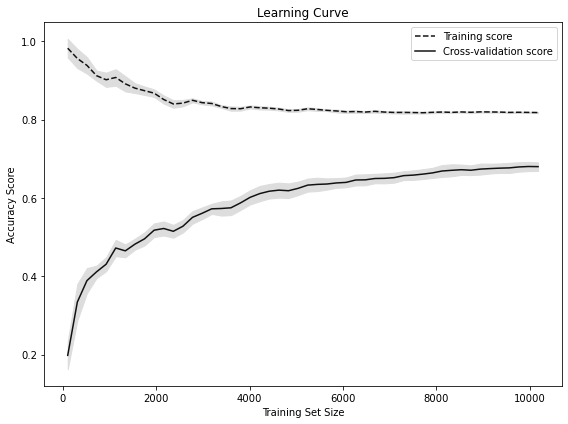

In [155]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize= (8,6))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(MultinomialNB(), test_x, test_y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))



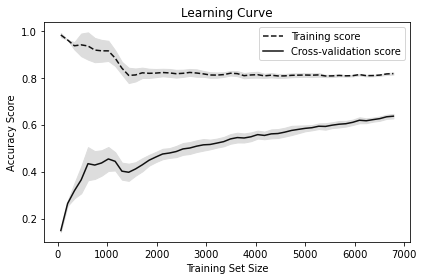

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()
